# Initialize system

In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math
from scipy.optimize import curve_fit
import pprint
import inspect 

top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths
import ePix320kM as devBoard

args = None

In [43]:
%run supportFunctions.ipynb
%run dataProcFunctions.ipynb

In [3]:
# ONLY RUN ONCE!
# Defining root
# If crashes, make sure the deve is correct.
root =  devBoard.Root(   
        top_level  = top_level,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        pciePgpEn  = False,
        justCtrl   = False,
        DDebugSize = 4000)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000400
UpTime       = 18:16:25
GitHash      = 0x1420ec1d27d3a15f69ee3c81d92a534be21a2320
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = "ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 21 Mar 2024 05:28:47 PM PDT
Builder      = dnajjar"
###################################################


In [11]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [12]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_75000018efb4ab01_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_RegisterControl.yml
Loading batcher configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_BatcherEventBuilder.yml
Loading packet register configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_75000018efb4ab01_PacketRegisters.yml
Taking asic off of reset
Loading ASICs and timing configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_ASIC_u1_PLLBypass.yml
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/..//config/ePixHRM

In [13]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

#run some triggers and exercise lanes and locks
frames = 100
rate = 5000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed


In [14]:
# Get locked lanes
time.sleep(3)
root.getLaneLocks()

# Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))

ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xffffff
ASIC0: 0x20000
ASIC1: 0x10045
ASIC2: 0x490000
ASIC3: 0x540140


In [15]:
# Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
for i in range (5):
    root.Trigger()
    
root.enableDataRcv(False)
root.enableAllAsics(False)

# Here we select which ASIC we want to test

In [16]:
ASIC = ASIC2
ASICNUM = 2
DATADEBUG= DEBUG2
PKREG = PKREG2

root.enableAsic(ASICNUM, True)

# Select which pixel we want to run the analysis on

Warning!! If you change the ref_row and ref_col here, you need to make sure that the chargeInjection() function works on the proper range of columns. 

This function is defined in dataProcFunctions notebook

In [17]:
ref_row = 100
ref_col = 150

# Run the following two cells once at initialization
The first cell might fail, that's ok. Stop it, then run the second one. Repeat if necessary.

In [21]:
lanesHackTest(root, PKREG, DATADEBUG)

PKREG.TimeoutCntLane[0]=0
PKREG.TimeoutCntLane[1]=0
PKREG.TimeoutCntLane[2]=0
PKREG.TimeoutCntLane[3]=0
PKREG.TimeoutCntLane[4]=0
PKREG.TimeoutCntLane[5]=0
PKREG.TimeoutCntLane[6]=0
PKREG.TimeoutCntLane[7]=0
PKREG.TimeoutCntLane[8]=0
PKREG.TimeoutCntLane[9]=0
PKREG.TimeoutCntLane[10]=0
PKREG.TimeoutCntLane[11]=0
PKREG.TimeoutCntLane[12]=0
PKREG.TimeoutCntLane[13]=0
PKREG.TimeoutCntLane[14]=0
PKREG.TimeoutCntLane[15]=0
PKREG.TimeoutCntLane[16]=0
PKREG.TimeoutCntLane[17]=0
PKREG.TimeoutCntLane[18]=0
PKREG.TimeoutCntLane[19]=0
PKREG.TimeoutCntLane[20]=0
PKREG.TimeoutCntLane[21]=0
PKREG.TimeoutCntLane[22]=0
PKREG.TimeoutCntLane[23]=0
Stop Triggers command executed
DataDebug[2]: descramble error
rawData length 12336
Stop Triggers command executed
Data Descrambled
(192, 384, 2049)
Delta Aquisition Counter: 2048
Number of frames received: (192, 384, 2049)


In [22]:
lanesHackDisable(root, PKREG, DATADEBUG)

PKREG.TimeoutCntLane[0]=1
PKREG.TimeoutCntLane[1]=1
PKREG.TimeoutCntLane[2]=1
PKREG.TimeoutCntLane[3]=1
PKREG.TimeoutCntLane[4]=1
PKREG.TimeoutCntLane[5]=1
PKREG.TimeoutCntLane[6]=1
PKREG.TimeoutCntLane[7]=1
PKREG.TimeoutCntLane[8]=1
PKREG.TimeoutCntLane[9]=0
PKREG.TimeoutCntLane[10]=1
PKREG.TimeoutCntLane[11]=1
PKREG.TimeoutCntLane[12]=1
PKREG.TimeoutCntLane[13]=1
PKREG.TimeoutCntLane[14]=1
PKREG.TimeoutCntLane[15]=1
PKREG.TimeoutCntLane[16]=0
PKREG.TimeoutCntLane[17]=1
PKREG.TimeoutCntLane[18]=1
PKREG.TimeoutCntLane[19]=0
PKREG.TimeoutCntLane[20]=1
PKREG.TimeoutCntLane[21]=1
PKREG.TimeoutCntLane[22]=0
PKREG.TimeoutCntLane[23]=1
ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xfeffff
ASIC0: 0x20000
ASIC1: 0x10045
ASIC2: 0x490200
ASIC3: 0x540140


# Set registers and variables

In [23]:
# Set analog settings
setAnalogSettings(ASIC0)
setAnalogSettings(ASIC1)
setAnalogSettings(ASIC2)
setAnalogSettings(ASIC3)

ASIC.CompTH_ePixM.set(0)

# Set best settings - pipoclk delay
setBestSettings(REGCTRL,ASIC0, ASIC1, ASIC2, ASIC3)

#sets HSDAC device
HSDAC.enable.set(True)
#reset status
HSDAC.WFEnabled.set(False)
HSDAC.waveformSource.set(0)
HSDAC.externalUpdateEn.set(False)
HSDAC.run.set(False)

R0 Width set to 7.808uS
R0 Delay set to 1.280uS
Acq1 Width set to 3.584uS
Acq1 Delay set to 4.864uS
-------------------------
Baseline time:    3.5839999999999996 uS
Integration time: 3.584 uS
Sampling done at: 8.448 uS
-------------------------
ASIC configured


# Optional: scan RefP/RefN analog references
Scans the references to find optimal SNR based on noise and gain (with charge injection).
The gain is calculated based on a linear fit.

Note: the min/max values in the chargeInjRamp function might need manual tuning to avoid saturation!
Visually inspect the plots at the end to make sure you're not fitting on a saturated point.

In [17]:
# WARNING! We set ADC gain to low, to avoid saturation during scan, as it will result in wrong values
ASIC.DHg.set(False)

--- Acquiring data value [0,0] ---
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
--- Acquiring data value [0,1] ---
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
--- Acquiring data value [0,2] ---
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
--- Acquiring data value [0,3] ---
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
--- Acquiring data value [1,0] ---
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of fram

KeyboardInterrupt: 

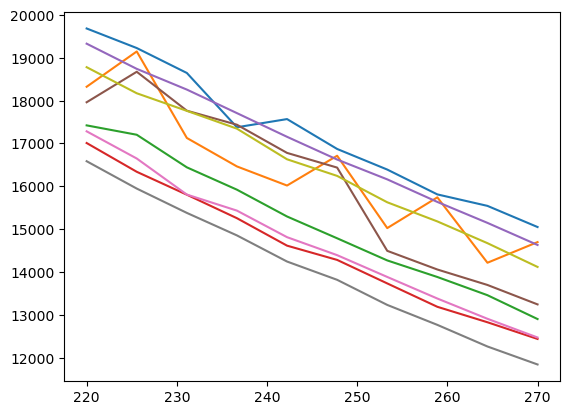

In [18]:
# Define empty arrays
noise   = np.empty([4,4])
gain    = np.empty([4,4])

for RefN_val, RefP_val in np.ndindex(4,4):
    print('--- Acquiring data value [{},{}] ---'.format(RefN_val,RefP_val))
    ASIC.RefinN.set(RefN_val)
    ASIC.RefinP.set(RefP_val)
    # Get ramps and calculate gain
    ChInjValues, pixelRamp = chargeInjRamp(DATADEBUG,AsicNum=ASICNUM, Min=220, Max=270, numSteps=10)
    pixelRamp = pixelRamp[ref_row, ref_col,:]
    
    plt.plot(ChInjValues, pixelRamp)
    gain[RefN_val,RefP_val] = np.polyfit(ChInjValues, pixelRamp, 1)[0]
    
    # Get darks and calculate noise
    data = getFrames(DATADEBUG, 1000)
    data_noisemap = np.std(data, axis=2)    
    noise[RefN_val,RefP_val] = data_noisemap[ref_row, ref_col]
    
plt.xlabel('Charge injection value [a.u.]')
plt.ylabel('Output [ADU]')

In [ ]:
# noise = noise[0:6,0:6]  
# gain = gain[0:6,0:6]    

snr = abs(gain)/noise

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot the images on each subplot
im1 = axes[0].imshow(abs(gain), cmap='inferno')
im2 = axes[1].imshow(noise, cmap='inferno')
im3 = axes[2].imshow(snr, cmap='inferno')

# Set titles for each subplot
axes[0].set_title('Gain')
axes[1].set_title('Noise')
axes[2].set_title('SNR')

axes[0].set_xlabel('RefInP')
axes[1].set_xlabel('RefInP')
axes[2].set_xlabel('RefInP')

axes[0].set_ylabel('RefInN')
axes[1].set_ylabel('RefInN')
axes[2].set_ylabel('RefInN')

# Optionally, display the axes on each subplot
axes[0].axis('on')
axes[1].axis('on')
axes[2].axis('on')

# Add colorbars to each subplot
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar3 = fig.colorbar(im3, ax=axes[2])

# Set colorbar labels (optional)
cbar1.set_label('Gain [ADU/PulserValue]')
cbar2.set_label('Noise [ADUs]')
cbar3.set_label('SNR [a.u.]')

# Show the plots
plt.tight_layout()
plt.show()

print('Recommended setting RefN/RefP:{}'.format(np.where(snr == snr.max())))


# Optional: scan Integration time

In [ ]:
# Set analog settings
setAnalogSettings(ASIC0)
setAnalogSettings(ASIC1)
setAnalogSettings(ASIC2)
setAnalogSettings(ASIC3)
setBestSettings(REGCTRL,ASIC0, ASIC1, ASIC2, ASIC3)
ASIC.CompTH_ePixM.set(0)

In [ ]:
# Define integration time values
intTimeValues = [100,140,180,200,240,280,320,400,560,720,880,1040]

# Define empty arrays
noise   = np.empty(np.shape(intTimeValues)[0])
gain    = np.empty(np.shape(intTimeValues)[0])
intTimeValues_us = np.empty(np.shape(intTimeValues)[0])

setSR0(40000, 2000)

for i,intTime in enumerate(intTimeValues):
    print(f'--- Acquiring data value {intTime} ---')
    print(f'-------------------------')
    setR0(100+intTime*2, 200)
    setAcq1(intTime, intTime+200)
    baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
    integration_time = REGCTRL.AcqWidth1_us.get()
    print(f'Baseline time:    {baseline_int_time} uS')
    print(f'Integration time: {integration_time} uS')
    print(f'-------------------------')

    
    # Get ramps and calculate gain
    ChInjValues, pixelRamp = chargeInjRamp(DATADEBUG,AsicNum=ASICNUM, Min=200, Max=250, numSteps=4, numSamples=4)
    pixelRamp = pixelRamp[ref_row, ref_col,:]
    gain[i] = np.polyfit(ChInjValues, pixelRamp, 1)[0]
    
    # Get darks and calculate noise
    data = getFrames(DATADEBUG, 1000)
    data_noisemap = np.std(data, axis=2)    
    noise[i] = np.median(data_noisemap)
    intTimeValues_us[i] = REGCTRL.AcqWidth1_us.get()
    

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

snr = abs(gain)/noise
axes[0].plot(intTimeValues_us,noise, 'o-')
axes[1].plot(intTimeValues_us,abs(gain), 'o-')
axes[2].plot(intTimeValues_us,snr, 'o-')

# Set titles for each subplot
axes[0].set_title('Noise')
axes[1].set_title('Gain')
axes[2].set_title('SNR')

axes[0].set_xlabel('Integration time [us]')
axes[1].set_xlabel('Integration time [us]')
axes[2].set_xlabel('Integration time [us]')

axes[0].set_ylabel('Noise [ADUs]')
axes[1].set_ylabel('Gain [a.u.]')
axes[2].set_ylabel('SNR [a.u.]')

# Optionally, display the axes on each subplot
axes[0].axis('on')
axes[1].axis('on')
axes[2].axis('on')

plt.tight_layout()
plt.show()


# Reset settings after sweeps

In [24]:
# Reset settings
setAnalogSettings(ASIC0)
setAnalogSettings(ASIC1)
setAnalogSettings(ASIC2)
setAnalogSettings(ASIC3)
setBestSettings(REGCTRL,ASIC0, ASIC1, ASIC2, ASIC3)

R0 Width set to 7.808uS
R0 Delay set to 1.280uS
Acq1 Width set to 3.584uS
Acq1 Delay set to 4.864uS
-------------------------
Baseline time:    3.5839999999999996 uS
Integration time: 3.584 uS
Sampling done at: 8.448 uS
-------------------------
ASIC configured


***
# Fixed High gain
To enable fixed-high gain, we set CompTH to the minimum (which corresponds to maximum signal amplitude).
In this way we prevent comparator from switching. 

We saturate pretty early, so no need to scan the whole pulser range.

Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Dark: 24311.973


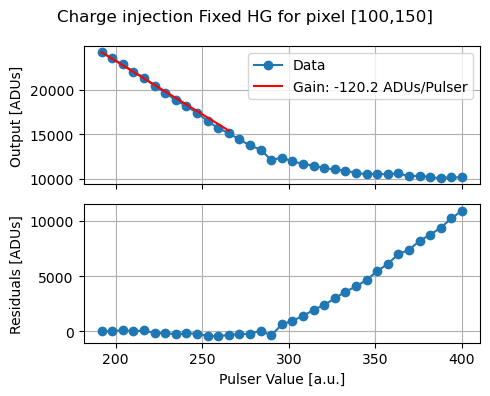

In [33]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC.CompTH_ePixM.set(0)
ASIC.Precharge_DAC_ePixM.set(40)

# Get the dark. We don't want to look at negative ramp
dark = np.mean(getFrames(DATADEBUG, 1000), axis=2)[ref_row,ref_col]

print('Dark:', dark)

# Get ramps
ChInjValues, PixOutValues = chargeInjRamp(DATADEBUG, AsicNum=ASICNUM, Min=100, Max=400, numSteps=60)
PixOutValues = PixOutValues[ref_row,ref_col,:]

# Crop to values above dark (note! signal is negative)
aboveDark = (PixOutValues < dark)
ChInjValues = ChInjValues[aboveDark]
PixOutValues = PixOutValues[aboveDark]

# Select fit region (!) manual selection
fit_indices = (ChInjValues <= 270)
ChInjValues_fit = ChInjValues[fit_indices]
PixOutValues_fit = PixOutValues[fit_indices]

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

# Data points and fit
ax1.plot(ChInjValues, PixOutValues,'o-', label='Fixed HG', c='red')

# Perform the linear fit using polyfit
residuals, slope, intercept = linearFitHG(ChInjValues,PixOutValues)
polyfit_function = np.poly1d([slope, intercept])
ax1.plot(ChInjValues_fit, polyfit_function(ChInjValues_fit), color='red', label='Gain: {:.1f} ADUs/Pulser'.format(slope))

ax1.set_ylabel("Output [ADUs]")
ax1.legend()
ax1.grid(True)

# Plot residuals
ax2.plot(ChInjValues, residuals, 'o-')
ax2.set_xlabel("Pulser Value [a.u.]")
ax2.set_ylabel("Residuals [ADUs]")
ax2.grid(True)

plt.suptitle('Charge injection Fixed HG for pixel [{},{}]'.format(ref_row,ref_col))
plt.tight_layout()

***
# Gain switching

We first scan the value of the threshold. The goal is to find the minimum non-linearity in the High-Gain region, without sacrificing dynamic range too much. 

We can ignore what happens at the LG region for the moment.

Sweep: CompTH_ePixM  12
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)



KeyboardInterrupt



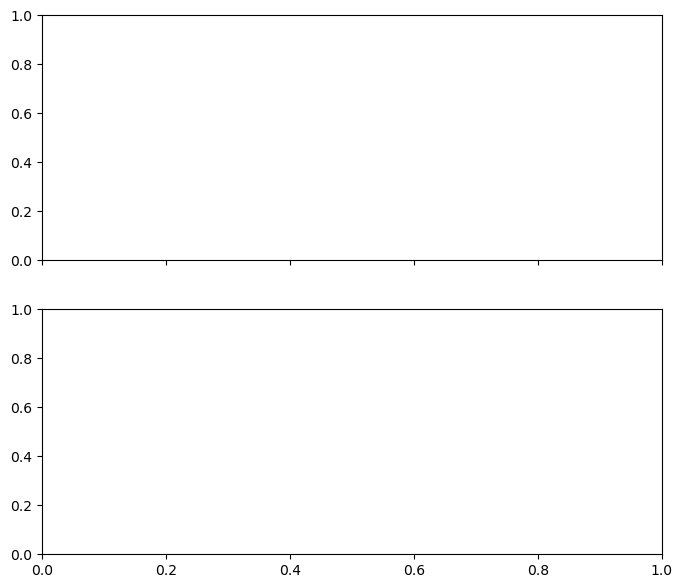

In [52]:
# Set Precharge to nominal value
ASIC.Precharge_DAC_ePixM.set(40)

# Scan the values of CompTH_ePixM
scanValues = [12,18,24,30]

# Generate colors for colormap
colors = genColors(len(scanValues))

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

# ---------------------------- 
# Scan starts here
for i, value in enumerate(scanValues):
    print('Sweep: CompTH_ePixM ', value)
    ASIC.CompTH_ePixM.set(value)
    # Get the dark. We don't want to look at negative ramp
    dark = np.mean(clearB16(getFrames(DATADEBUG, 1000)), axis=2)[ref_row,ref_col]

    # Get ramps
    ChInjValues, PixOutValues = chargeInjRamp(DATADEBUG, AsicNum=ASICNUM, Min=100, Max=400, numSteps=30)
    PixOutValues = PixOutValues[ref_row,ref_col,:]

    indexHG = isHG(PixOutValues.astype(int))
    indexLG = ~indexHG

    # Split ramp into HG and LG region
    ChInjValuesHG = ChInjValues[indexHG]
    PixOutValuesHG = PixOutValues[indexHG]

    ChInjValuesLG = ChInjValues[indexLG]
    PixOutValuesLG = PixOutValues[indexLG]
    
    # Crop to values above dark (note! signal is negative)
    PixOutValuesLG = clearB16(PixOutValuesLG.astype(int))
    aboveDark    = (PixOutValuesHG < dark)
    ChInjValuesHG  = ChInjValuesHG[aboveDark]
    PixOutValuesHG = PixOutValuesHG[aboveDark]

    residuals, slope, intercept = linearFitHG(ChInjValuesHG,PixOutValuesHG)
    
    # Plot and fit
    ax1.plot(ChInjValuesHG, PixOutValuesHG,'o-', label=value,color=colors[i])
    ax1.plot(ChInjValuesLG, PixOutValuesLG,'o-', label=value,color=colors[i])
    ax2.plot(ChInjValuesHG, residuals,'o-', label=value,color=colors[i])


plt.suptitle('Charge injection scan Soft Low Gain for pixel [{},{}]'.format(ref_row,ref_col))
ax1.set_ylabel("Output [ADUs]")
ax2.set_ylabel("Residuals [ADUs]")
ax2.set_xlabel("Pulser Value [a.u.]")
ax1.legend()
ax2.legend()
ax1.grid(True)
ax2.grid(True)

plt.tight_layout()

2nd step is to scan the Precharge_DAC_ePixM register. Goal is to minimize non-linear behavior in the LG region.


Sweep: CompTH_ePixM  24
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: CompTH_ePixM  30/30
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: CompTH_ePixM  36/30
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: CompTH_ePixM  42/30
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: CompTH_ePixM  48/30
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: CompTH

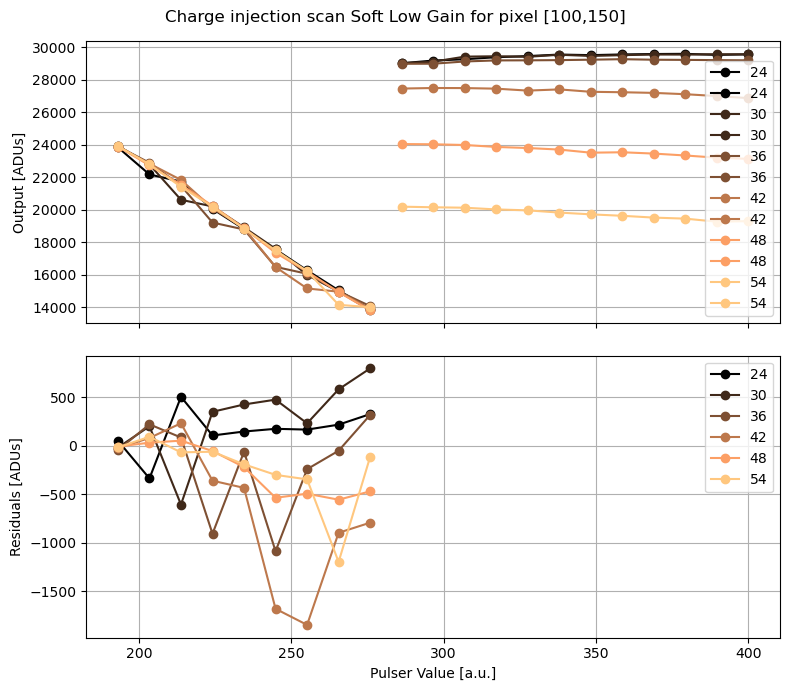

In [53]:
# Set threshold
ASIC.CompTH_ePixM.set(24)

# Scan the values of CompTH_ePixM
scanValues = [24,30,36,42,48,54]

# Generate colors for colormap
colors = genColors(len(scanValues))

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

# ---------------------------- 
# Scan starts here
for i, value in enumerate(scanValues):
    print('Sweep: CompTH_ePixM ', value)
    ASIC.Precharge_DAC_ePixM.set(value)
    # Get the dark. We don't want to look at negative ramp
    dark = np.mean(clearB16(getFrames(DATADEBUG, 1000)), axis=2)[ref_row,ref_col]

    # Get ramps
    ChInjValues, PixOutValues = chargeInjRamp(DATADEBUG, AsicNum=ASICNUM, Min=100, Max=400, numSteps=30)
    PixOutValues = PixOutValues[ref_row,ref_col,:]

    indexHG = isHG(PixOutValues.astype(int))
    indexLG = ~indexHG

    # Split ramp into HG and LG region
    ChInjValuesHG = ChInjValues[indexHG]
    PixOutValuesHG = PixOutValues[indexHG]

    ChInjValuesLG = ChInjValues[indexLG]
    PixOutValuesLG = PixOutValues[indexLG]
    
    # Crop to values above dark (note! signal is negative)
    PixOutValuesLG = clearB16(PixOutValuesLG.astype(int))
    aboveDark    = (PixOutValuesHG < dark)
    ChInjValuesHG  = ChInjValuesHG[aboveDark]
    PixOutValuesHG = PixOutValuesHG[aboveDark]

    residuals, slope, intercept = linearFitHG(ChInjValuesHG,PixOutValuesHG)
    
    # Plot and fit
    ax1.plot(ChInjValuesHG, PixOutValuesHG,'o-', label=value,color=colors[i])
    ax1.plot(ChInjValuesLG, PixOutValuesLG,'o-', color=colors[i])
    ax2.plot(ChInjValuesHG, residuals,'o-', label=value,color=colors[i])


plt.suptitle('Charge injection scan Soft Low Gain for pixel [{},{}]'.format(ref_row,ref_col))
ax1.set_ylabel("Output [ADUs]")
ax2.set_ylabel("Residuals [ADUs]")
ax2.set_xlabel("Pulser Value [a.u.]")
ax1.legend()
ax2.legend()
ax1.grid(True)
ax2.grid(True)

plt.tight_layout()

Now we set the best parameters we found above and we perform a high resolution scan, plotting gains and residuals 

Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Dark: 24318.373


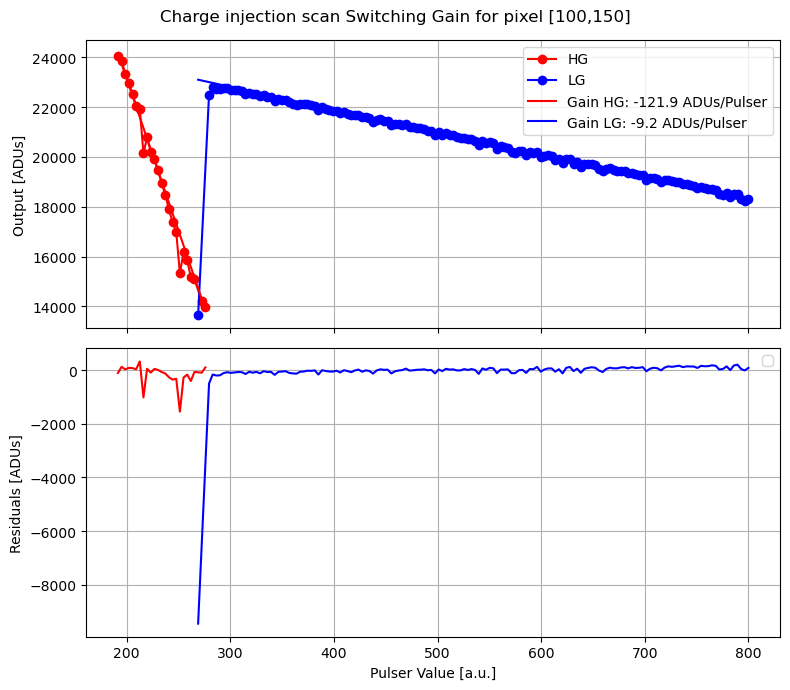

In [61]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC.CompTH_ePixM.set(24)
ASIC.Precharge_DAC_ePixM.set(50)

# Get the dark. We don't want to look at negative ramp
dark = np.mean(clearB16(getFrames(DATADEBUG, 1000)), axis=2)[ref_row,ref_col]

print('Dark:', dark)

# Get ramps
ChInjValues, PixOutValues = chargeInjRamp(DATADEBUG, AsicNum=ASICNUM, Min=100, Max=800, numSteps=200, numSamples=1)
PixOutValues = PixOutValues[ref_row,ref_col,:]

indexHG = isHG(PixOutValues.astype(int))
indexLG = ~indexHG

# Split ramp into HG and LG region
ChInjValuesHG = ChInjValues[indexHG]
PixOutValuesHG = PixOutValues[indexHG]

ChInjValuesLG = ChInjValues[indexLG]
PixOutValuesLG = PixOutValues[indexLG]

# Crop to values above dark, or with gain switched (note! signal is negative)
aboveDark    = (PixOutValuesHG < dark)
ChInjValuesHG  = ChInjValuesHG[aboveDark]
PixOutValuesHG = PixOutValuesHG[aboveDark]

# In Gain switching, filtering happens afterwards
PixOutValuesHG = clearB16(PixOutValuesHG.astype(int))
PixOutValuesLG = clearB16(PixOutValuesLG.astype(int))

# Plot and fit
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

ax1.plot(ChInjValuesHG, PixOutValuesHG,'o-', label='HG', color='red')
ax1.plot(ChInjValuesLG, PixOutValuesLG,'o-', label='LG', color='blue')

plt.ylabel("Output [ADUs]")

# Fit
fit_indices = (ChInjValues <= 1000)
ChInjValues_fit = ChInjValues[fit_indices]
PixOutValues_fit = PixOutValues[fit_indices]

# Perform the linear fit using polyfit
residuals, slope, intercept = linearFitHG(ChInjValuesHG,PixOutValuesHG)
polyfit_function = np.poly1d([slope, intercept])
ax1.plot(ChInjValuesHG, polyfit_function(ChInjValuesHG), color='red', label='Gain HG: {:.1f} ADUs/Pulser'.format(slope))
ax2.plot(ChInjValuesHG, residuals, color='red')

# Perform the linear fit using polyfit
residuals, slope, intercept = linearFitLG(ChInjValuesLG,PixOutValuesLG)
polyfit_function = np.poly1d([slope, intercept])
ax1.plot(ChInjValuesLG, polyfit_function(ChInjValuesLG), color='blue', label='Gain LG: {:.1f} ADUs/Pulser'.format(slope))
ax2.plot(ChInjValuesLG, residuals, color='blue')

plt.suptitle('Charge injection scan Switching Gain for pixel [{},{}]'.format(ref_row,ref_col))
ax1.set_ylabel("Output [ADUs]")
ax2.set_ylabel("Residuals [ADUs]")
ax2.set_xlabel("Pulser Value [a.u.]")
ax1.legend()
ax2.legend()
ax1.grid(True)
ax2.grid(True)

plt.tight_layout()

***
# Soft Low gain
To force the pixel to switch in low-gain, we need to set the threshold below the baseline.
This forces the pixel to switch at each frame.

However, this might require tuning of the Threshold as well as the Precharge registers.

The cells below scan the values of these two register to find the optimal values, which avoid saturation and non-linearities.

Sweep: CompTH_ePixM  34
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: CompTH_ePixM  40/40
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: CompTH_ePixM  46/40
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: CompTH_ePixM  52/40
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: CompTH_ePixM  58/40
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)


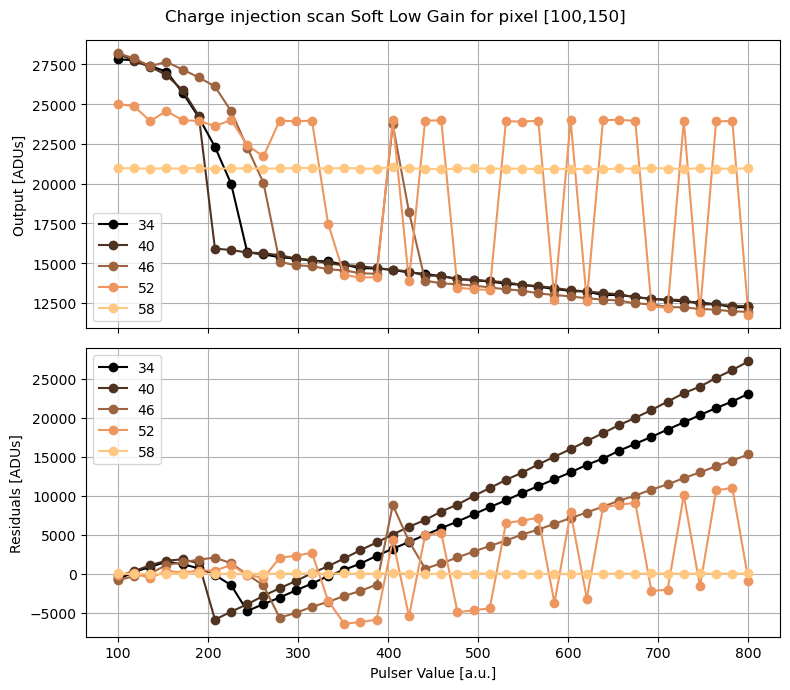

In [57]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC.Precharge_DAC_ePixM.set(63)

# Scan the values of Precharge_DAC
scanValues = [28,34,40,46,52,58]

# Generate colors for colormap
colors = genColors(len(scanValues))

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

# ---------------------------- 
# Scan starts here
for i, value in enumerate(scanValues):
    print('Sweep: CompTH_ePixM ', value)
    ASIC.CompTH_ePixM.set(value)
    # Get the dark. We don't want to look at negative ramp
    dark = np.mean(clearB16(getFrames(DATADEBUG, 1000)), axis=2)[ref_row,ref_col]

    # Get ramps
    ChInjValues, PixOutValues = chargeInjRamp(DATADEBUG, AsicNum=ASICNUM, Min=100, Max=800, numSteps=40)
    PixOutValues = PixOutValues[ref_row,ref_col,:]
    
    # Crop to values above dark (note! signal is negative)
    PixOutValues = clearB16(PixOutValues.astype(int))
    residuals, slope, intercept = linearFitHG(ChInjValues,PixOutValues)
    
    # Plot and fit
    ax1.plot(ChInjValues, PixOutValues,'o-', label=value,color=colors[i])
    ax2.plot(ChInjValues, residuals,'o-', label=value,color=colors[i])


plt.suptitle('Scanning CompTH_ePixM for soft low gain [{},{}]'.format(ref_row,ref_col))
ax1.set_ylabel("Output [ADUs]")
ax2.set_ylabel("Residuals [ADUs]")
ax2.set_xlabel("Pulser Value [a.u.]")
ax1.legend()
ax2.legend()
ax1.grid(True)
ax2.grid(True)

plt.tight_layout()

Sweep: Precharge  0
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: Precharge  16 19/20
Stop Triggers command executed


/tmp/ipykernel_240817/4175376287.py:21: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=1, w=weights)


Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: Precharge  32 19/20
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: Precharge  48 19/20
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Sweep: Precharge  63 19/20
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)


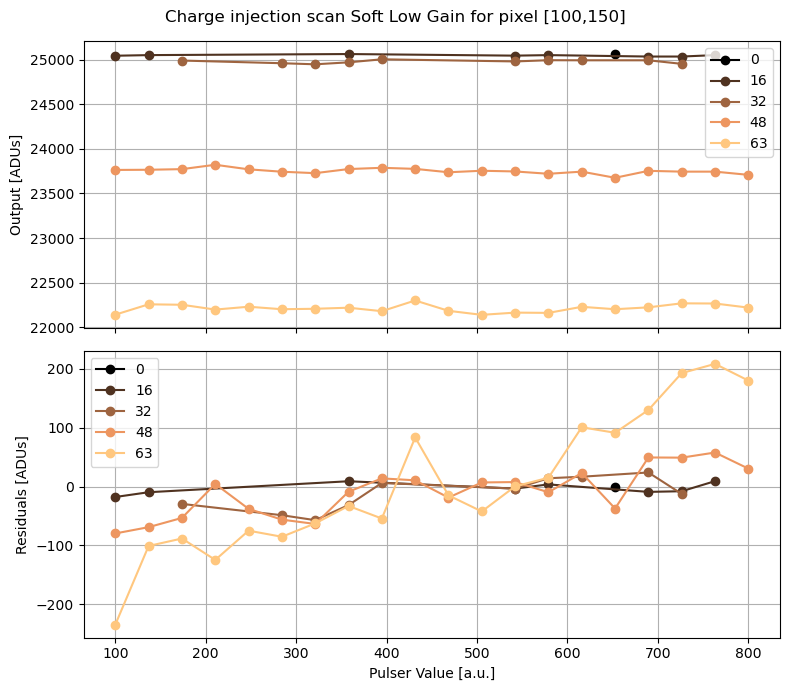

In [56]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC.CompTH_ePixM.set(56)

# Scan the values of Precharge_DAC
scanValues = [0,16,32,48,63]

# Generate colors for colormap
colors = genColors(len(scanValues))

# Plot and fit
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

# ---------------------------- 
# Scan starts here
for i, value in enumerate(scanValues):
    print('Sweep: Precharge ', value)
    ASIC.Precharge_DAC_ePixM.set(value)
    # Get the dark. We don't want to look at negative ramp
    dark = np.mean(clearB16(getFrames(DATADEBUG, 1000)), axis=2)[ref_row,ref_col]

    # Get ramps
    ChInjValues, PixOutValues = chargeInjRamp(DATADEBUG, AsicNum=ASICNUM, Min=100, Max=800, numSteps=20)
    PixOutValues = PixOutValues[ref_row,ref_col,:]
    

    # Crop to values above dark (note! signal is negative)
    PixOutValues = clearB16(PixOutValues.astype(int))
    aboveDark    = (PixOutValues < dark)
    ChInjValues  = ChInjValues[aboveDark]
    PixOutValues = PixOutValues[aboveDark]

    residuals, slope, intercept = linearFitLG(ChInjValues,PixOutValues)
    
    # Plot and fit
    ax1.plot(ChInjValues, PixOutValues,'o-', label=value,color=colors[i])
    ax2.plot(ChInjValues, residuals,'o-', label=value,color=colors[i])

plt.suptitle('Charge injection scan Soft Low Gain for pixel [{},{}]'.format(ref_row,ref_col))
ax1.set_ylabel("Output [ADUs]")
ax2.set_ylabel("Residuals [ADUs]")
ax2.set_xlabel("Pulser Value [a.u.]")
ax1.legend()
ax2.legend()
ax1.grid(True)
ax2.grid(True)

plt.tight_layout()

Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 1000)
Delta Aquisition Counter: 1000
Number of frames received: (192, 384, 1000)
Dark: 21068.06


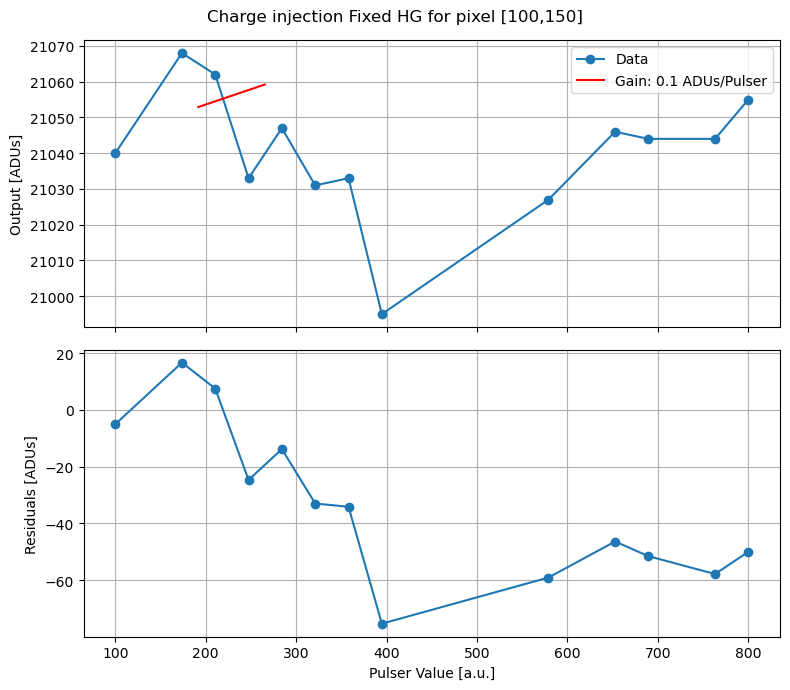

In [37]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC.CompTH_ePixM.set(63)
ASIC.Precharge_DAC_ePixM.set(63)

# Get the dark. We don't want to look at negative ramp
dark = np.mean(clearB16(getFrames(DATADEBUG, 1000)), axis=2)[ref_row,ref_col]

print('Dark:', dark)

# Get ramps
ChInjValues, PixOutValues = chargeInjRamp(DATADEBUG, AsicNum=ASICNUM, Min=100, Max=800, numSteps=60)
PixOutValues = PixOutValues[ref_row,ref_col,:]

# Crop to values above dark (note! signal is negative)
PixOutValues = clearB16(PixOutValues.astype(int))
aboveDark    = (PixOutValues < dark)
ChInjValues  = ChInjValues[aboveDark]
PixOutValues = PixOutValues[aboveDark]

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

# Data points and fit
ax1.plot(ChInjValues, PixOutValues,'o-', label='Data')

# Perform the linear fit using polyfit
residuals, slope, intercept = linearFitHG(ChInjValues,PixOutValues)
polyfit_function = np.poly1d([slope, intercept])
ax1.plot(ChInjValues_fit, polyfit_function(ChInjValues_fit), color='red', label='Gain: {:.1f} ADUs/Pulser'.format(slope))

ax1.set_ylabel("Output [ADUs]")
ax1.legend()
ax1.grid(True)

# Plot residuals
ax2.plot(ChInjValues, residuals, 'o-')
ax2.set_xlabel("Pulser Value [a.u.]")
ax2.set_ylabel("Residuals [ADUs]")
ax2.grid(True)

plt.suptitle('Charge injection scan Soft Low Gain for pixel [{},{}]'.format(ref_row,ref_col))
plt.tight_layout()